In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

# ML
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import joblib

import warnings
warnings.filterwarnings('ignore')

In [91]:
df_ten = pd.read_csv('df_ten.csv')

In [92]:
df_ten.sample(3)

,A_B365,A_PS,A_Pts,A_Rank,B_B365,B_PS,B_Pts,B_Rank,Best of,Court,...,Surface,vincitore,A_hand,A_dob,A_ioc,A_height,B_hand,B_dob,B_ioc,B_height
0,1.12,1.14,4595.0,4.0,6.0,7.15,716.0,78.0,3,Outdoor,...,Clay,B,R,26,AUT,185.0,R,22,RUS,188.0


In [93]:
df_ten.fillna(df_ten.median(), inplace=True)

In [94]:
europa =  ['ESP', 'FRA', 'GER', 'RUS', 'ITA', 'AUS', 'CZE', 'CRO',
       'SRB', 'SUI', 'GBR', 'BEL', 'AUT', 'SVK', 'NED', 'SWE', 'ROU',
       'FIN', 'POR', 'POL', 'BUL', 'CYP', 'BLR', 'UKR', 'SLO', 'LAT', 'NOR',  'BIH', 'GRE',
       'GEO', 'LUX', 'DEN', 'HUN', 'LTU', 'MDA', 'EST', 'IRL', 'BAR', 'ESA']
sud_america= ['ARG', 'BRA', 'COL', 'URU', 'ECU', 'PER', 'CHI', 'BOL', 'MEX', 'PAR']
nord_america= ['USA', 'CAN']
africa = ['RSA', 'TUN', 'MAR', 'TUR', 'EGY', 'ALG', 'ZIM']
asia = ['JPN', 'KAZ', 'UZB', 'ISR', 'IND', 'THA', 'KOR', 'ARM', 'CHN', 'TPE', 'PHI', 'MON', 'PAK']
oceania = ['NZL']

In [95]:
cont_A = []
for x in df_ten.A_ioc:
    if x in europa:
        cont_A.append('europa')
    elif x in sud_america:
        cont_A.append('sud_america')
    elif x in nord_america:
        cont_A.append('nord_america')
    elif x in africa:
        cont_A.append('africa')
    elif x in asia:
        cont_A.append('asia')
    else:
        cont_A.append('oceania')

df_ten.A_ioc = cont_A

In [97]:
cont_B = []
for x in df_ten.B_ioc:
    if x in europa:
        cont_B.append('europa')
    elif x in sud_america:
        cont_B.append('sud_america')
    elif x in nord_america:
        cont_B.append('nord_america')
    elif x in africa:
        cont_B.append('africa')
    elif x in asia:
        cont_B.append('asia')
    else:
        cont_B.append('oceania')

df_ten.B_ioc = cont_B

In [111]:
df_ten['diff_bet'] = df_ten.A_B365 - df_ten.B_B365

In [112]:
X, y = df_ten.drop(columns=['vincitore', 'A_PS', 'B_PS', 'Best of', 'Series', 'Court', 'Surface',
                            'A_B365', 'B_B365']), df_ten.vincitore

In [113]:
X = pd.get_dummies(X, drop_first=True)

In [114]:
le = LabelEncoder()
y = le.fit_transform(y)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

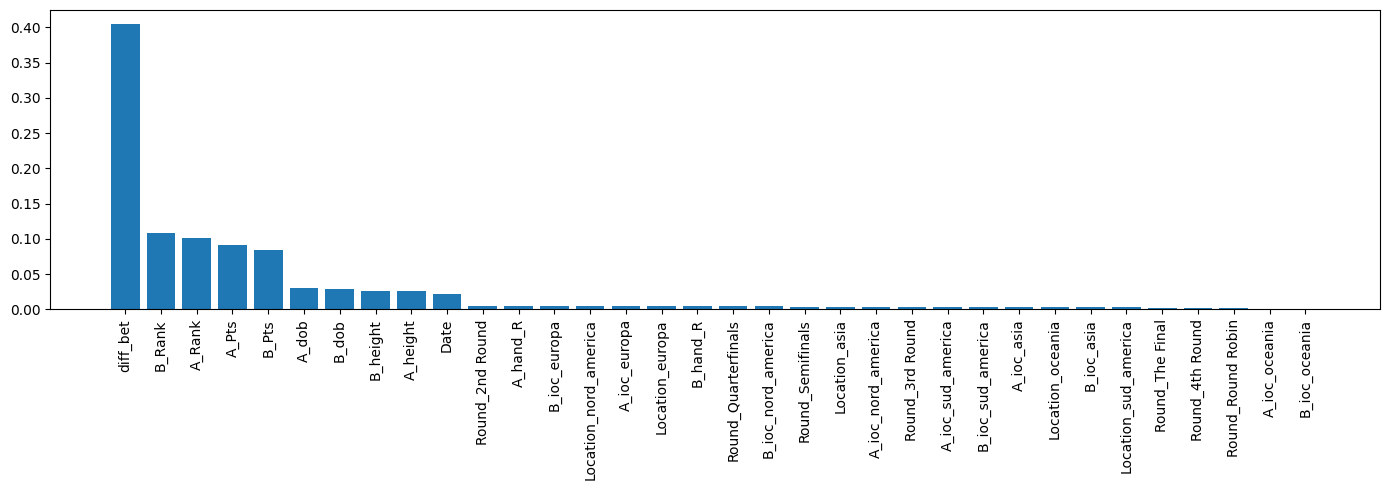

In [117]:
forest = RandomForestClassifier(n_estimators=200, max_depth=12)
forest.fit(X_train, y_train)

importanza = forest.feature_importances_
indice = np.argsort(importanza)[::-1]

plt.figure(figsize=(14, 5))
plt.bar(range(X.shape[1]), importanza[indice])
plt.xticks(range(X.shape[1]), X.columns[indice], rotation=90)
plt.tight_layout()

In [118]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

joblib.dump(sc, 'standard_scaler_joblib')

In [391]:
param_grid = {
    'C': scipy.stats.loguniform(0.01, 100.0),
    'fit_intercept': [True, False],
    'l1_ratio': [0.1, 0.3, 0.5, 0.8, 1.0],
    }

rgs = RandomizedSearchCV(estimator=LogisticRegression(random_state=1, penalty='elasticnet', solver='saga'), 
                        param_distributions=param_grid,
                        n_iter=50,
                        scoring='accuracy',
                        cv=3)

rgs.fit(X_train_std, y_train)
print(f'Combinazione migliore: {rgs.best_params_}')
print(f'Punteggio migliore: {rgs.best_score_}')
print(f'Test score: {rgs.score(X_test_std, y_test)}')

Combinazione migliore: {'C': 0.05329484866703377, 'fit_intercept': True, 'l1_ratio': 0.1}
Punteggio migliore: 0.6959902094881579
Test score: 0.702008205571151


In [394]:
param_grid = {
    'max_depth': list(range(10, 25)),
    'n_estimators': list(range(350, 450)),
    'max_leaf_nodes': list(range(3, 30)),
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5]
    }

rgs = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=1), 
                        param_distributions=param_grid,
                        n_iter=50,
                        scoring='accuracy',
                        cv=3)

rgs.fit(X_train_std, y_train)
print(f'Combinazione migliore: {rgs.best_params_}')
print(f'Punteggio migliore: {rgs.best_score_}')
print(f'Test score: {rgs.score(X_test_std, y_test)}')

Combinazione migliore: {'n_estimators': 366, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_leaf_nodes': 29, 'max_depth': 21}
Punteggio migliore: 0.6923427638998872
Test score: 0.6998488447419564


In [392]:
param_grid = {
    'ccp_alpha': scipy.stats.loguniform(0.00000008, 0.0000001),
    'learning_rate': [0.03, 0.05, 0.07],
    'loss': ['log_loss', 'deviance', 'exponential'],
    'max_depth': [3, 6, 9, 12],
    'max_features': [None, 'auto'],
    'max_leaf_nodes': list(range(3, 30)),
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
    'n_estimators': list(range(250, 450))
    }

rgs = RandomizedSearchCV(estimator=GradientBoostingClassifier(random_state=1), 
                        param_distributions=param_grid,
                        n_iter=30,
                        scoring='accuracy',
                        cv=3)

rgs.fit(X_train_std, y_train)
print(f'Combinazione migliore: {rgs.best_params_}')
print(f'Punteggio migliore: {rgs.best_score_}')
print(f'Test score: {rgs.score(X_test_std, y_test)}')

Combinazione migliore: {'ccp_alpha': 8.860274703338875e-08, 'learning_rate': 0.03, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 26, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 299}
Punteggio migliore: 0.6939265231684785
Test score: 0.7013603973223925


In [119]:
lr = LogisticRegression(C=0.05329484866703377, fit_intercept=True, l1_ratio=0.1)
forest = RandomForestClassifier(n_estimators=366, min_samples_split=5, min_samples_leaf=1, max_leaf_nodes=29, max_depth=21)
gb = GradientBoostingClassifier(ccp_alpha=8.860274703338875e-08, learning_rate=0.03, loss='deviance', max_depth=3, max_features='auto', max_leaf_nodes=26, min_samples_leaf=1, min_samples_split=5, n_estimators=299)

In [397]:
param_grid = {
    'weights': [[1, 1, 1], [1.2, 1, 1], [1, 1.2, 1], [1, 1, 1.2]]
    }
gs = GridSearchCV(estimator= VotingClassifier(estimators=[('lr', lr), ('forest', forest), ('gb', gb)], voting='soft'), 
                  param_grid=param_grid,
                  cv=3,
                  scoring='accuracy')
gs.fit(X_train_std, y_train)
print(f'Combinazione migliore: {gs.best_params_}')
print(f'Punteggio migliore: {gs.best_score_}')
print(f'Test score: {gs.score(X_test_std, y_test)}')

Combinazione migliore: {'weights': [1, 1, 1.2]}
Punteggio migliore: 0.6947423991553284
Test score: 0.7033038220686677


In [120]:
status = 0
best = 0
for x in range(10):
    vc = VotingClassifier(estimators=[('lr', lr), ('forest', forest), ('gb', gb)], voting='soft', weights=[1, 1, 1.2])
    vc.fit(X_train_std, y_train)
    score = vc.score(X_test_std, y_test)
    
    status += 1
    print(status, score)
    
    if score > best:
        best = score
        joblib.dump(vc, 'vc_clf_joblib')

1 0.7028719499028288
2 0.7026560138199093
3 0.7037356942345065
4 0.7028719499028288
5 0.7030878859857482
6 0.7041675664003455
7 0.7033038220686677
8 0.7033038220686677
9 0.7033038220686677
10 0.7028719499028288


In [ ]:
best